In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import cv2
import matplotlib
matplotlib.rcParams["image.interpolation"] = None
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist.matching import matching, matching_dataset
from stardist.models import Config2D, StarDist2D, StarDistData2D

np.random.seed(42)
lbl_cmap = random_label_cmap()

In [2]:
img = imread('/groups/zimmer/shared_projects/wbfm/test_volumes/one_volume.tif')
mask = np.load('/groups/zimmer/shared_projects/wbfm/ground_truth/gt_3d_raw.npy')
n_channel = 1

In [3]:
print(img.shape)
print(mask.shape)

(33, 700, 900)
(32, 700, 900)


In [4]:
X = [img[i] for i in range(1,33)]
Y = [mask[i].astype(int) for i in range(0,32)]
print(len(X))
print(len(Y))
print(X[0].shape)
print(Y[0].shape)

32
32
(700, 900)
(700, 900)


In [5]:
axis_norm = (0,1)   # normalize channels independently
X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X)]
Y = [fill_label_holes(y) for y in tqdm(Y)]

100%|██████████| 32/32 [00:00<00:00, 128.56it/s]


In [6]:
val_ind = [2,10]
trn_ind = [0,1,3,4,5,6,7,8,9,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31]
X_val, Y_val = [X[i] for i in val_ind], [Y[i] for i in val_ind]
X_trn, Y_trn = [X[i] for i in trn_ind], [Y[i] for i in trn_ind] 
#print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))

- training:        30
- validation:       2


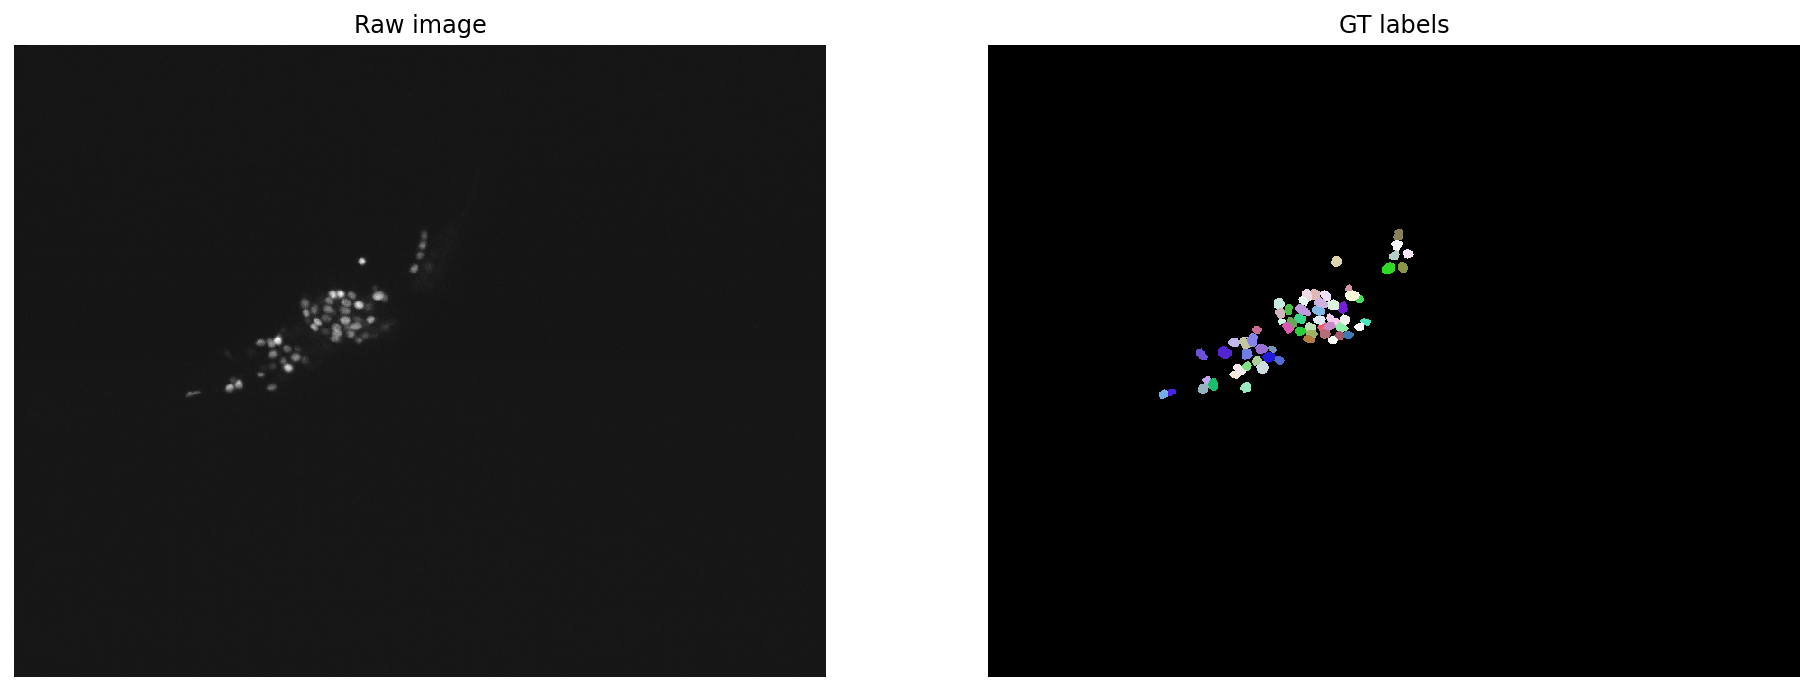

In [7]:
i = min(9, len(X)-1)
img, lbl = X[i], Y[i]
assert img.ndim in (2,3)
img = img if img.ndim==2 else img[...,:3]
plt.figure(figsize=(16,10))
plt.subplot(121); plt.imshow(img,cmap='gray');   plt.axis('off'); plt.title('Raw image')
plt.subplot(122); plt.imshow(lbl,cmap=lbl_cmap); plt.axis('off'); plt.title('GT labels')
None;

In [8]:
# 32 is a good default choice (see 1_data.ipynb)
n_rays = 32

# Use OpenCL-based computations for data generator during training (requires 'gputools')
use_gpu = False and gputools_available()

# Predict on subsampled grid for increased efficiency and larger field of view
grid = (2,2)

conf = Config2D (
    n_rays       = n_rays,
    grid         = grid,
    use_gpu      = use_gpu,
    n_channel_in = n_channel,
)
print(conf)
vars(conf)

Config2D(axes='YXC', backbone='unet', grid=(2, 2), n_channel_in=1, n_channel_out=33, n_dim=2, n_rays=32, net_conv_after_unet=128, net_input_shape=(None, None, 1), net_mask_shape=(None, None, 1), train_background_reg=0.0001, train_batch_size=4, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5', train_completion_crop=32, train_dist_loss='mae', train_epochs=400, train_foreground_only=0.9, train_learning_rate=0.0003, train_loss_weights=(1, 0.2), train_n_val_patches=None, train_patch_size=(256, 256), train_reduce_lr={'factor': 0.5, 'patience': 40, 'min_delta': 0}, train_shape_completion=False, train_steps_per_epoch=100, train_tensorboard=True, unet_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_kernel_size=(3, 3), unet_last_activation='relu', unet_n_conv_per_depth=2, unet_n_depth=3, unet_n_filter_base=32, unet_pool=(2, 2), unet_prefix='', use_gpu=False)


{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 33,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'n_rays': 32,
 'grid': (2, 2),
 'backbone': 'unet',
 'unet_n_depth': 3,
 'unet_kernel_size': (3, 3),
 'unet_n_filter_base': 32,
 'unet_n_conv_per_depth': 2,
 'unet_pool': (2, 2),
 'unet_activation': 'relu',
 'unet_last_activation': 'relu',
 'unet_batch_norm': False,
 'unet_dropout': 0.0,
 'unet_prefix': '',
 'net_conv_after_unet': 128,
 'net_input_shape': (None, None, 1),
 'net_mask_shape': (None, None, 1),
 'train_shape_completion': False,
 'train_completion_crop': 32,
 'train_patch_size': (256, 256),
 'train_background_reg': 0.0001,
 'train_foreground_only': 0.9,
 'train_dist_loss': 'mae',
 'train_loss_weights': (1, 0.2),
 'train_epochs': 400,
 'train_steps_per_epoch': 100,
 'train_learning_rate': 0.0003,
 'train_batch_size': 4,
 'train_n_val_patches': None,
 'train_tensorboard': True,

In [9]:
if use_gpu:
    from csbdeep.utils.tf import limit_gpu_memory
    # adjust as necessary: limit GPU memory to be used by TensorFlow to leave some to OpenCL-based computations
    limit_gpu_memory(0.8)
    # alternatively, try this:
    # limit_gpu_memory(None, allow_growth=True)

In [10]:
#model = StarDist2D(conf, name='stardistNiklas', basedir='models')
# laod previous model
model = StarDist2D(None, name='stardistNiklas', basedir='models')

Loading network weights from 'weights_best.h5'.
Couldn't load thresholds from 'thresholds.json', using default values. (Call 'optimize_thresholds' to change that.)
Using default values: prob_thresh=0.5, nms_thresh=0.4.


In [11]:
median_size = calculate_extents(list(Y), np.median)
fov = np.array(model._axes_tile_overlap('YX'))
print(f"median object size:      {median_size}")
print(f"network field of view :  {fov}")
if any(median_size > fov):
    print("WARNING: median object size larger than field of view of the neural network.")

median object size:      [11. 11.]
network field of view :  [94 94]


In [12]:
def random_fliprot(img, mask): 
    assert img.ndim >= mask.ndim
    axes = tuple(range(mask.ndim))
    perm = tuple(np.random.permutation(axes))
    img = img.transpose(perm + tuple(range(mask.ndim, img.ndim))) 
    mask = mask.transpose(perm) 
    for ax in axes: 
        if np.random.rand() > 0.5:
            img = np.flip(img, axis=ax)
            mask = np.flip(mask, axis=ax)
    return img, mask 

def random_intensity_change(img):
    img = img*np.random.uniform(0.6,2) + np.random.uniform(-0.2,0.2)
    return img


def augmenter(x, y):
    """Augmentation of a single input/label image pair.
    x is an input image
    y is the corresponding ground-truth label image
    """
    x, y = random_fliprot(x, y)
    x = random_intensity_change(x)
    # add some gaussian noise
    sig = 0.02*np.random.uniform(0,1)
    x = x + sig*np.random.normal(0,1,x.shape)
    return x, y

def plot_img_label(img, lbl, img_title="image", lbl_title="label", **kwargs):
    fig, (ai,al) = plt.subplots(1,2, figsize=(12,5), gridspec_kw=dict(width_ratios=(1.25,1)))
    im = ai.imshow(img, cmap='gray', clim=(0,1))
    ai.set_title(img_title)    
    fig.colorbar(im, ax=ai)
    al.imshow(lbl, cmap=lbl_cmap)
    al.set_title(lbl_title)
    plt.tight_layout()

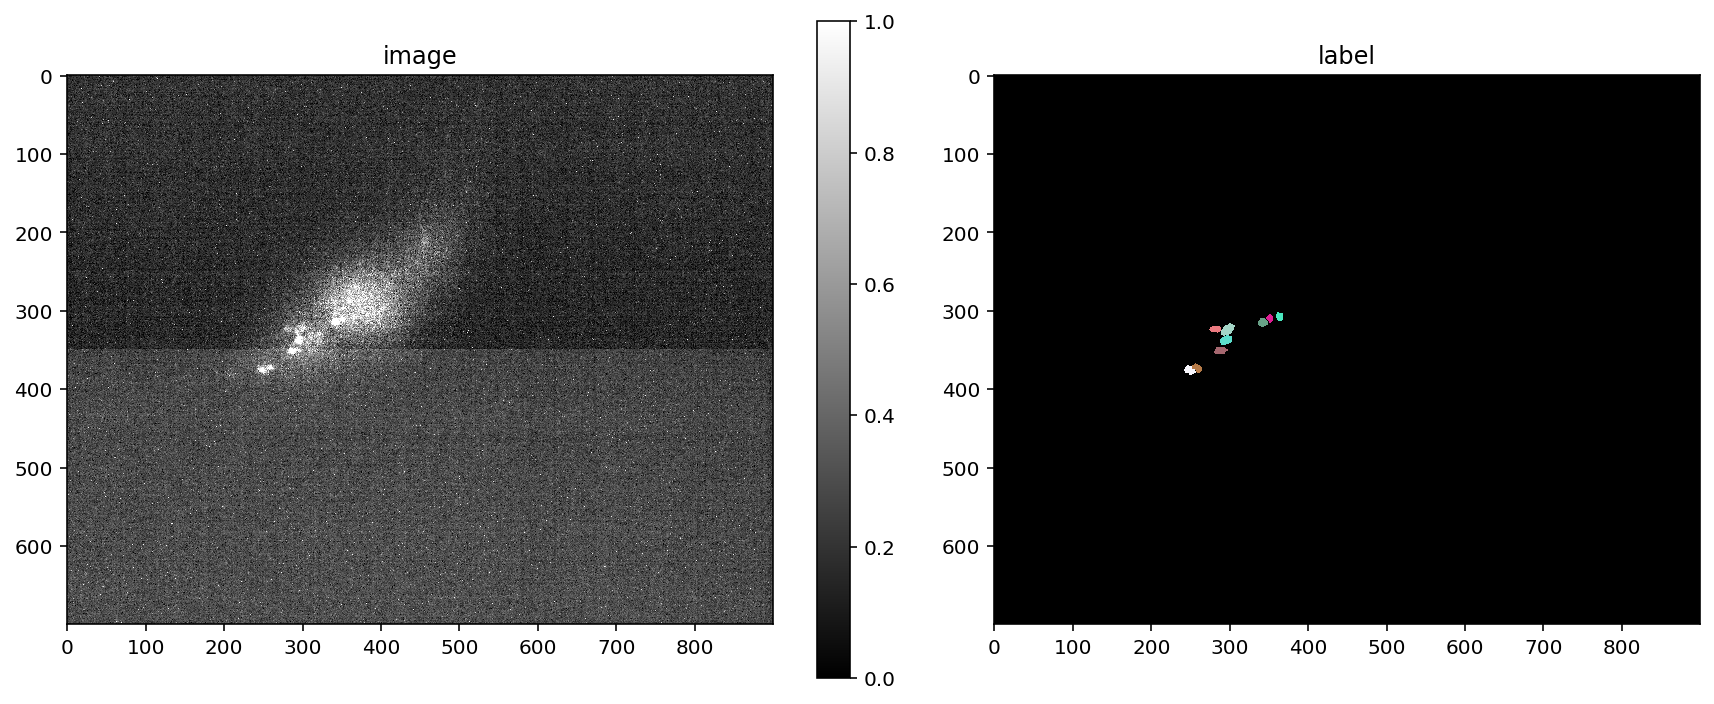

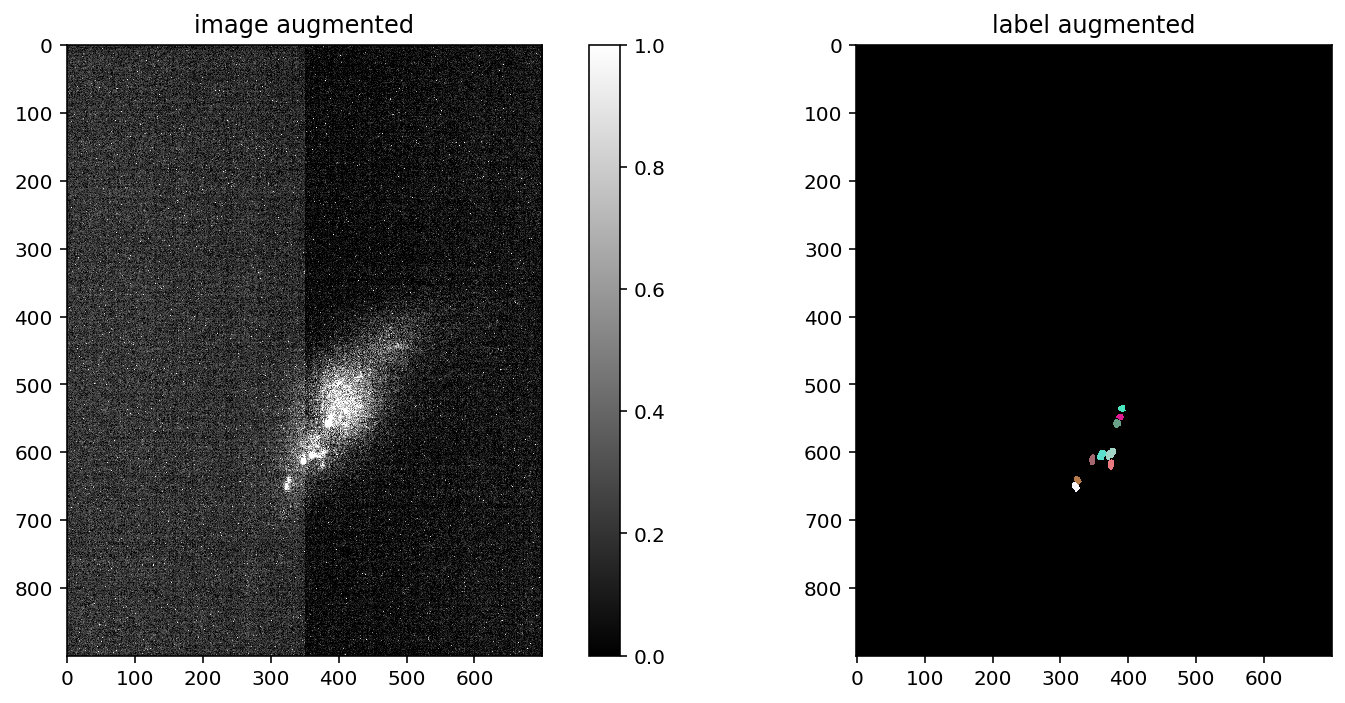

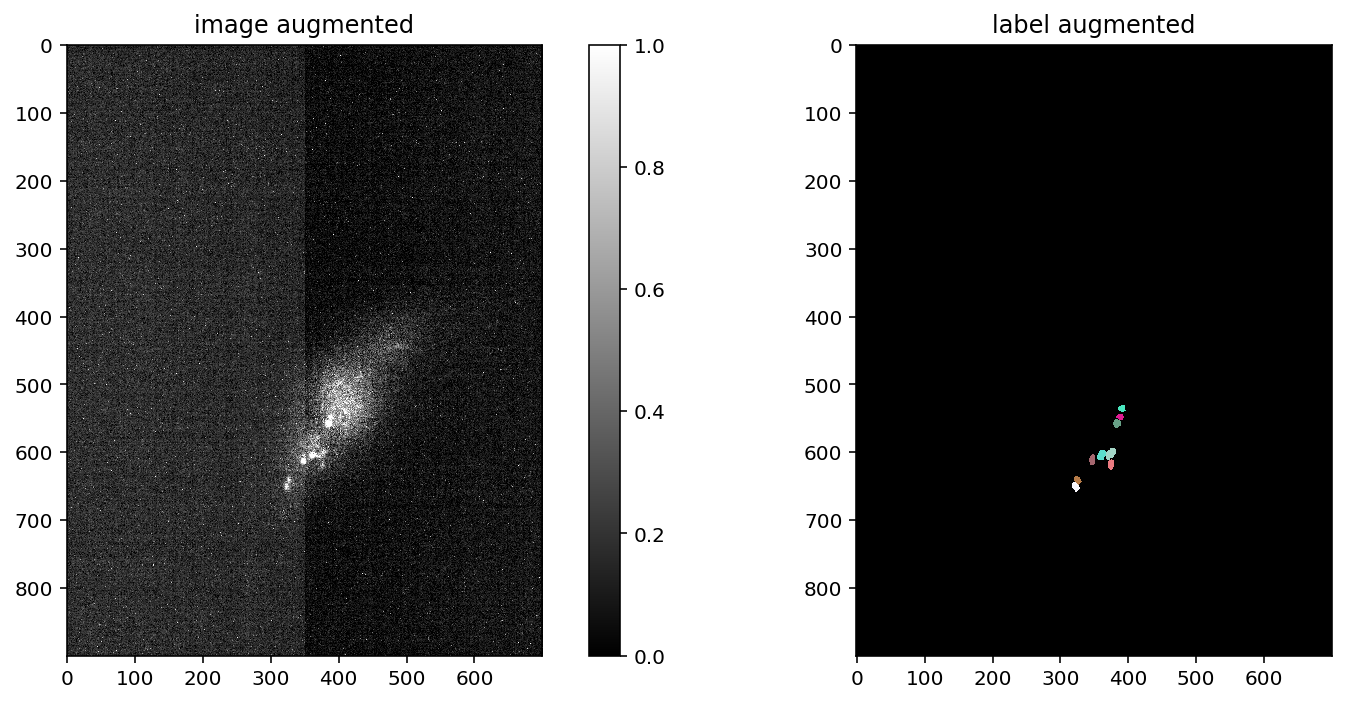

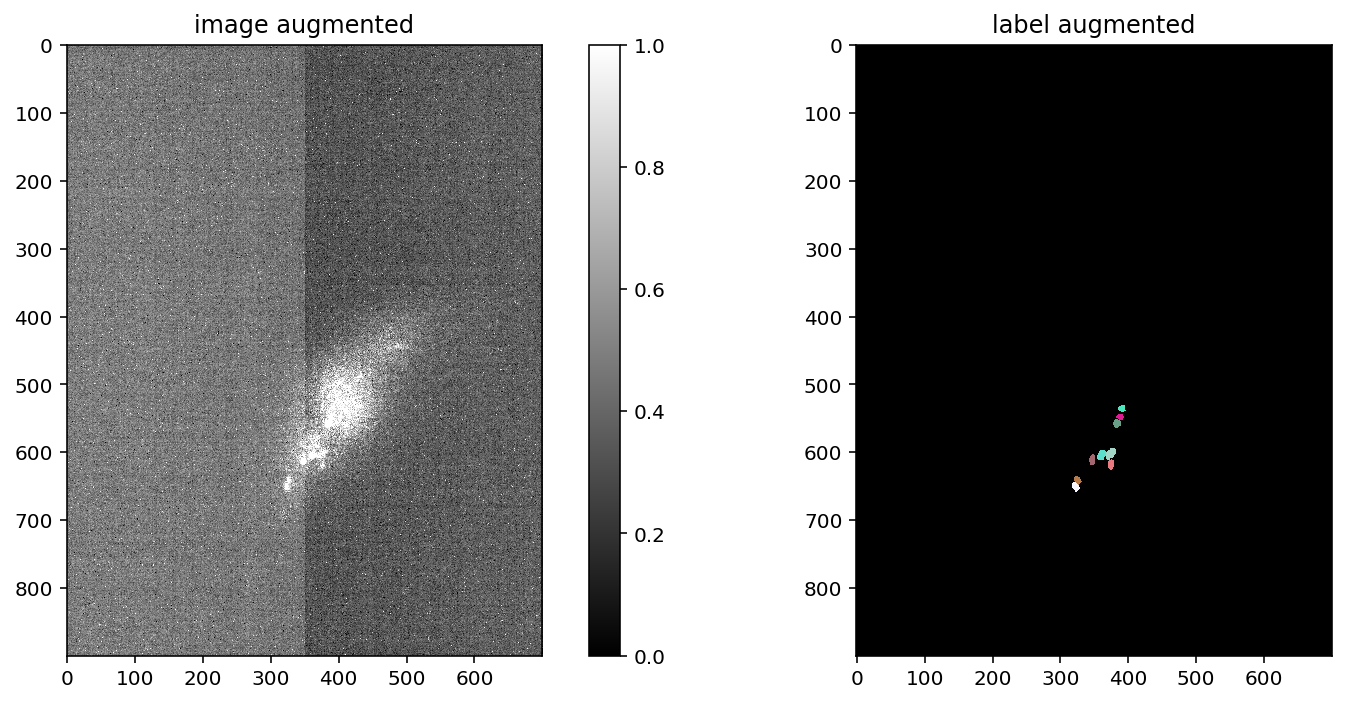

In [13]:
# plot some augmented examples
img, lbl = X[0],Y[0]
plot_img_label(img, lbl)
for _ in range(3):
    img_aug, lbl_aug = augmenter(img,lbl)
    plot_img_label(img_aug, lbl_aug, img_title="image augmented", lbl_title="label augmented")

In [ ]:
quick_demo = False

if quick_demo:
    print (
        "NOTE: This is only for a quick demonstration!\n"
        "      Please set the variable 'quick_demo = False' for proper (long) training.",
        file=sys.stderr, flush=True
    )
    model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter,
                epochs=2, steps_per_epoch=10)

    print("====> Stopping training and loading previously trained demo model from disk.", file=sys.stderr, flush=True)
    model = StarDist2D.from_pretrained('2D_demo')
else:
    model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter)
None;

Epoch 1/400
100/100 [==============================] - 59s 574ms/step - loss: 0.2298 - prob_loss: 0.0189 - dist_loss: 1.0543 - prob_kld: 0.0050 - dist_relevant_mae: 1.0539 - dist_relevant_mse: 2.2511 - val_loss: 0.1942 - val_prob_loss: 0.0059 - val_dist_loss: 0.9417 - val_prob_kld: 0.0023 - val_dist_relevant_mae: 0.9413 - val_dist_relevant_mse: 1.6577
Epoch 2/400
100/100 [==============================] - 55s 552ms/step - loss: 0.2256 - prob_loss: 0.0216 - dist_loss: 1.0199 - prob_kld: 0.0055 - dist_relevant_mae: 1.0196 - dist_relevant_mse: 2.1385 - val_loss: 0.2082 - val_prob_loss: 0.0054 - val_dist_loss: 1.0142 - val_prob_kld: 0.0017 - val_dist_relevant_mae: 1.0138 - val_dist_relevant_mse: 1.8575
Epoch 3/400
100/100 [==============================] - 56s 557ms/step - loss: 0.2230 - prob_loss: 0.0201 - dist_loss: 1.0145 - prob_kld: 0.0056 - dist_relevant_mae: 1.0142 - dist_relevant_mse: 2.1442 - val_loss: 0.1956 - val_prob_loss: 0.0063 - val_dist_loss: 0.9466 - val_prob_kld: 0.0027 - 

In [44]:
if quick_demo:
    model.optimize_thresholds(X_val[:2], Y_val[:2])
else:
    model.optimize_thresholds(X_val, Y_val)

NMS threshold = 0.5:  75%|███████▌  | 15/20 [00:02<00:00,  6.26it/s, 0.541 -> 0.805]


Using optimized values: prob_thresh=0.538237, nms_thresh=0.3.


In [45]:
Y_val_pred = [model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)[0]
              for x in tqdm(X_val)]

100%|██████████| 2/2 [00:01<00:00,  1.54it/s]


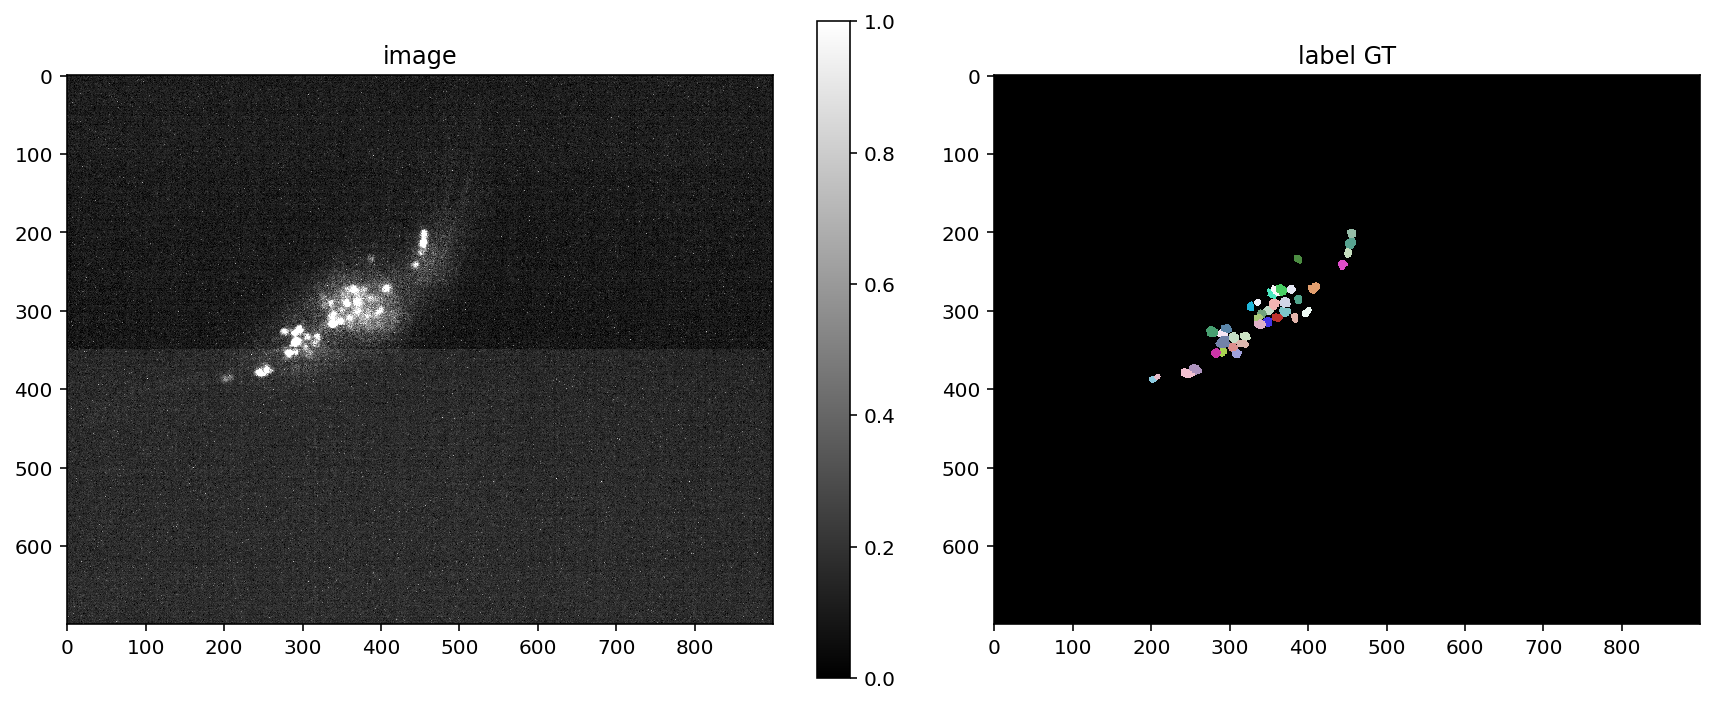

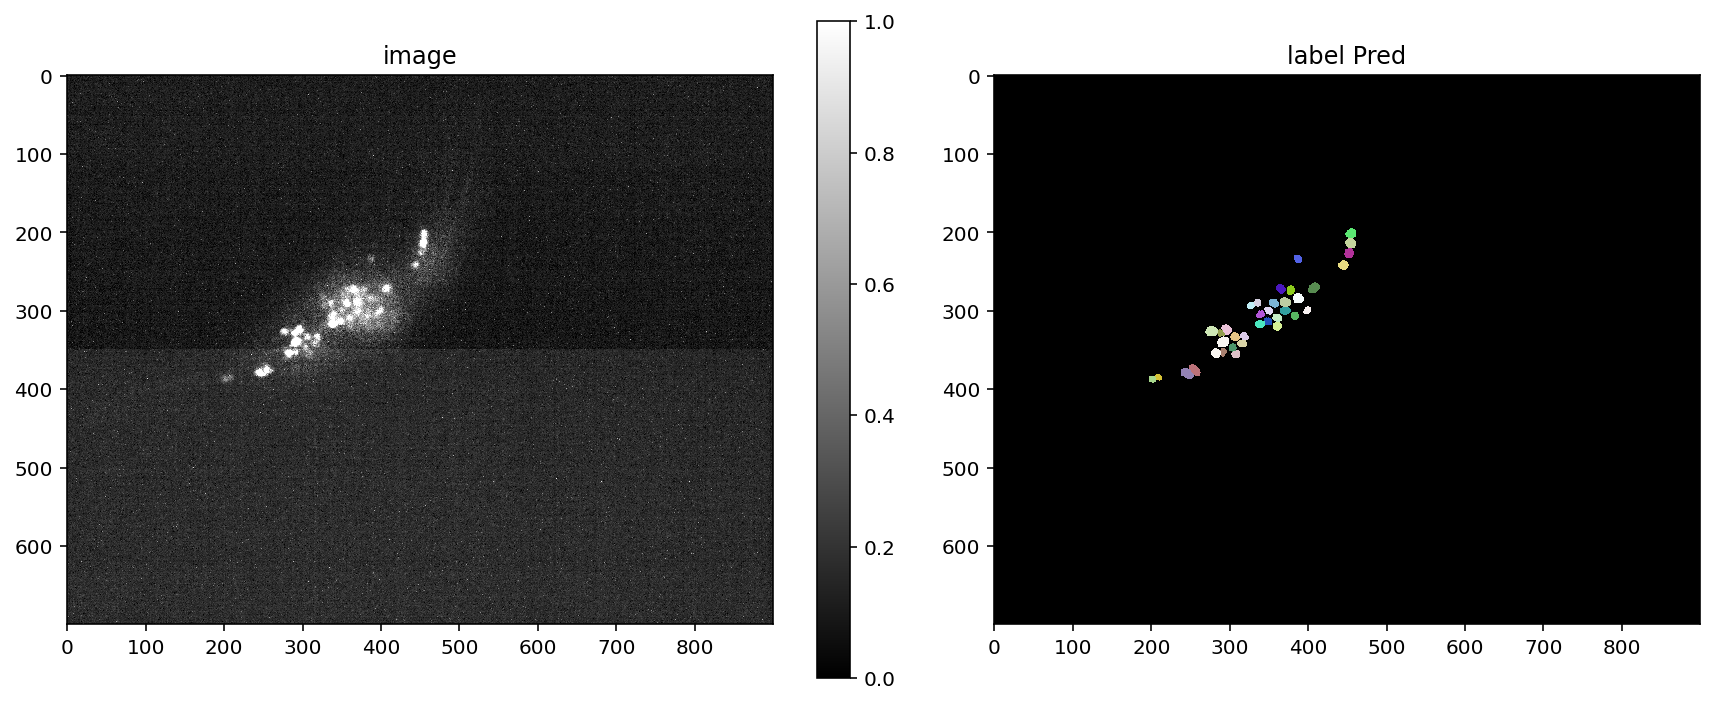

In [46]:
plot_img_label(X_val[0],Y_val[0], lbl_title="label GT")
plot_img_label(X_val[0],Y_val_pred[0], lbl_title="label Pred")

In [48]:
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset(Y_val, Y_val_pred, thresh=t, show_progress=False) for t in tqdm(taus)]

100%|██████████| 9/9 [00:00<00:00, 26.75it/s]


In [49]:
stats[taus.index(0.5)]

DatasetMatching(criterion='iou', thresh=0.5, fp=7, tp=102, fn=4, precision=0.9357798165137615, recall=0.9622641509433962, accuracy=0.9026548672566371, f1=0.9488372093023256, n_true=106, n_pred=109, mean_true_score=0.7374663485179955, mean_matched_score=0.7663865974794856, panoptic_quality=0.7271761203991398, by_image=False)

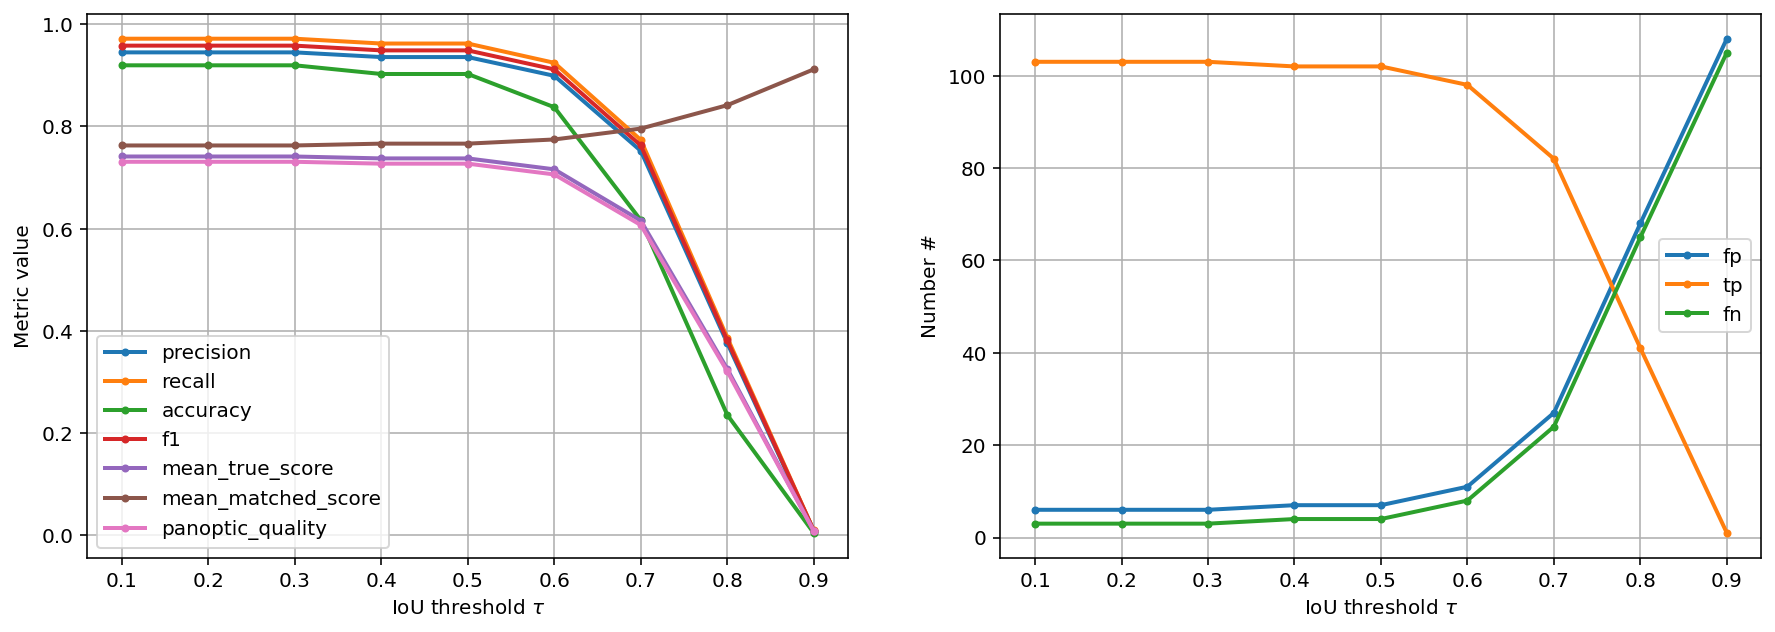

In [50]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'):
    ax1.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax1.set_xlabel(r'IoU threshold $\tau$')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()

for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU threshold $\tau$')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend();

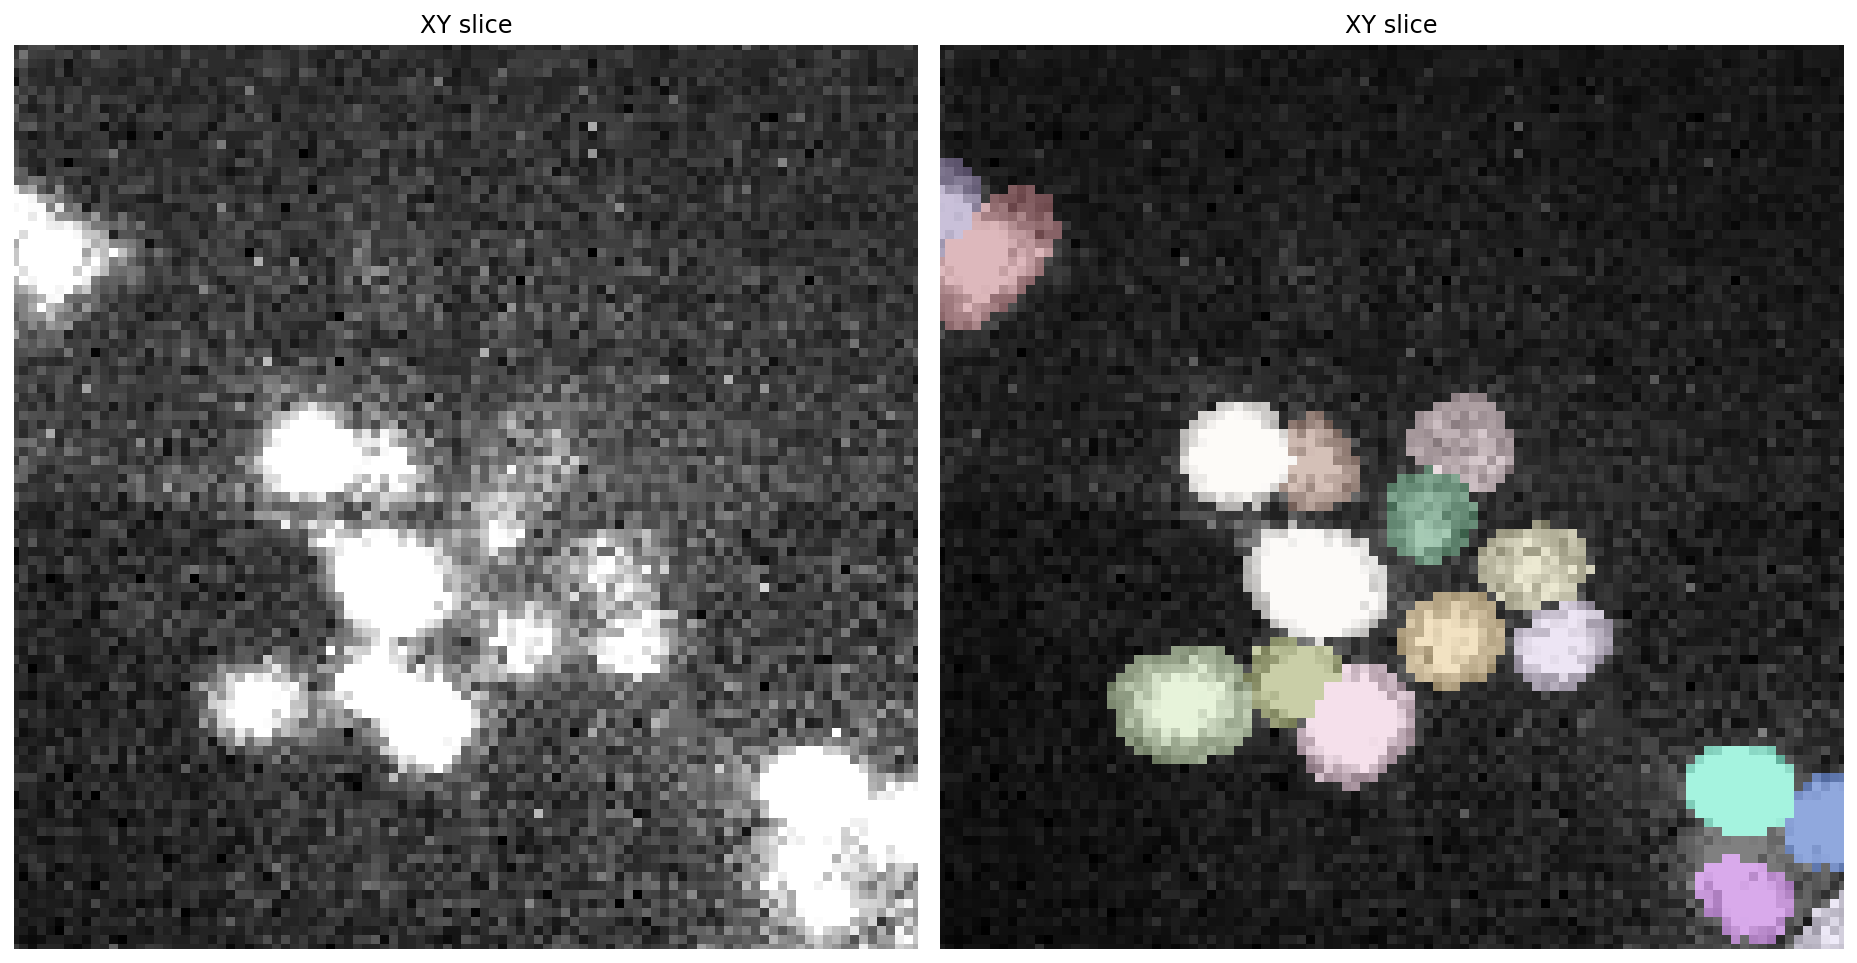

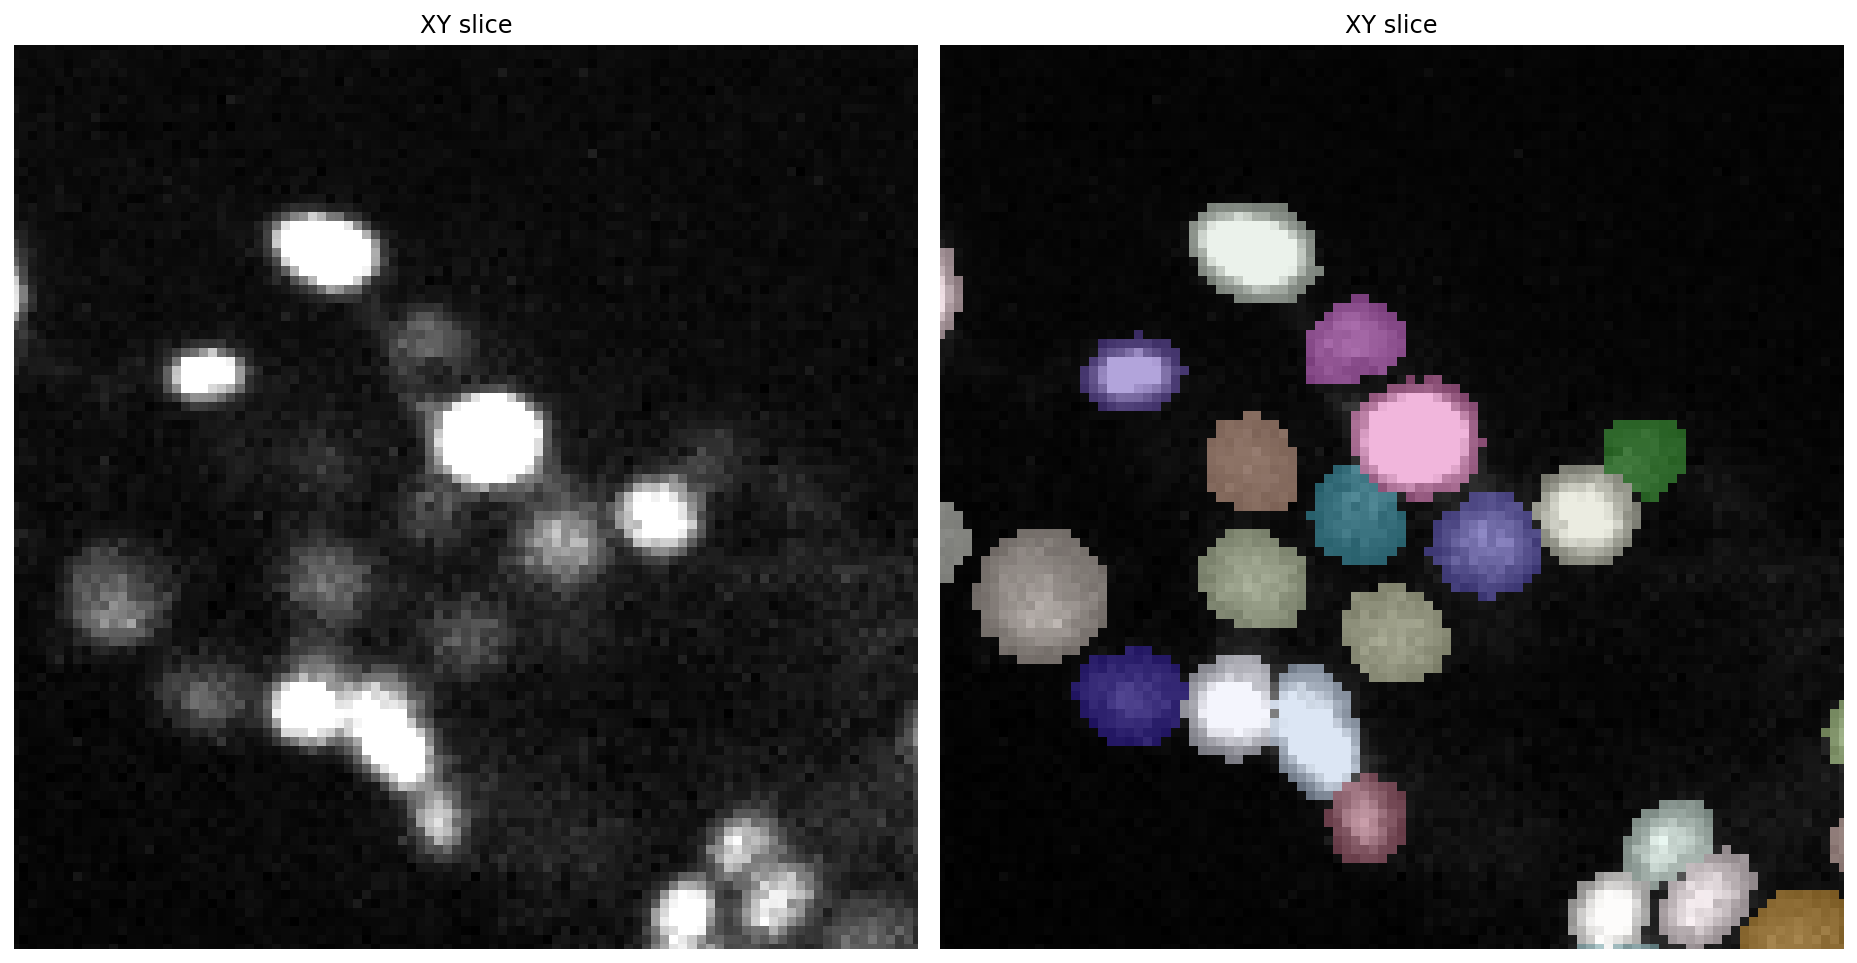

In [56]:
for z in range(len(X_val)):
    plt.figure(figsize=(13,8))
    #img_show = tempImage if tempImage.ndim==3 else tempImage[...,:3]    
    plt.subplot(121); plt.imshow(X_val[z],   cmap='gray', clim=(0,1)); plt.axis('off'); plt.title('XY slice')
    plt.axis([250,350,300,400])
    plt.subplot(122); plt.imshow(X_val[z],   cmap='gray', clim=(0,1)); plt.axis('off'); plt.title('XY slice')
    plt.axis([250,350,300,400])
    plt.imshow(Y_val_pred[z], cmap=lbl_cmap, alpha=0.5)
    plt.tight_layout()
    plt.show()